In [28]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [2]:
device = "mps" if torch.backends.mps.is_available() else "cpu"
device = torch.device(device)
print('Using {} device'.format(device))
device = torch.device('cpu')

Using mps device


In [3]:
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")
y_test -= 769
y_train_valid -= 769

In [4]:
idx_val = np.random.choice(2115, 400, replace=False)
idx_tra = np.array(list(set(range(2115)).difference(set(idx_val))))
X_train, X_val = X_train_valid[idx_tra], X_train_valid[idx_val] 
y_train, y_val = y_train_valid[idx_tra], y_train_valid[idx_val]

### Shape of data

In [5]:
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


# To torch.tensor

In [6]:
X_train = torch.from_numpy(X_train).float()
X_train = X_train[:,None,:,:]
y_train = torch.from_numpy(y_train).long()
X_val = torch.from_numpy(X_val).float()
X_val = X_val[:,None,:,:]
y_val = torch.from_numpy(y_val).long()
X_test = torch.from_numpy(X_test).float()
X_test = X_test[:,None,:,:]
y_test = torch.from_numpy(y_test).long()

# Dataset Class

In [7]:
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
val_dataset = torch.utils.data.TensorDataset(X_val, y_val)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

In [8]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

# Network

In [9]:
class MSA(nn.Module):
    def __init__(self, hidden_d, n_heads=2):
        super(MSA, self).__init__()
        self.d = hidden_d
        self.n_heads = n_heads

        d_head = int(self.d / n_heads)
        self.q_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.k_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.v_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.d_head = d_head
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, sequences):
        # Sequences has shape (N, seq_length, token_dim)
        # We go into shape    (N, seq_length, n_heads, token_dim / n_heads)
        # And come back to    (N, seq_length, item_dim)  (through concatenation)
        result = []
        for sequence in sequences:
            seq_result = []
            for head in range(self.n_heads):
                q_mapping = self.q_mappings[head]
                k_mapping = self.k_mappings[head]
                v_mapping = self.v_mappings[head]

                seq = sequence[:, head * self.d_head: (head + 1) * self.d_head]
                q, k, v = q_mapping(seq), k_mapping(seq), v_mapping(seq)

                attention = self.softmax(q @ k.T / (self.d_head ** 0.5))
                seq_result.append(attention @ v)
            result.append(torch.hstack(seq_result))
        return torch.cat([torch.unsqueeze(r, dim=0) for r in result])

In [10]:
class ViTBlock(nn.Module):
    def __init__(self, hidden_d, n_heads, mlp_ratio=4):
        super(ViTBlock, self).__init__()
        self.hidden_d = hidden_d
        self.n_heads = n_heads

        self.norm1 = nn.LayerNorm(hidden_d)
        self.mhsa = MSA(hidden_d, n_heads)
        self.norm2 = nn.LayerNorm(hidden_d)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_d, mlp_ratio * hidden_d),
            nn.GELU(),
            nn.Linear(mlp_ratio * hidden_d, hidden_d)
        )

    def forward(self, x):
        out = x + self.mhsa(self.norm1(x))
        out = out + self.mlp(self.norm2(out))
        return out

In [11]:
def patch_gen(x, patch_h, patch_w):
    n, c, h, w = x.shape
    patch_num_h = int(22/patch_h)
    patch_num_w = int(1000/patch_w)
    patch_num = patch_num_h * patch_num_w
    patch_size = patch_h * patch_w
    patches = torch.zeros(n, patch_num, patch_size)

    for idx, x_ in enumerate(x):
        for i in range(patch_num_h):
            for j in range(patch_num_w):
                patch = x_[:, i * patch_h:(i + 1) * patch_h, j * patch_w:(j + 1) * patch_w]
                patches[idx,i*patch_num_w+j,:] = patch.flatten()
    return patches.to(device)
    
def get_positional_embeddings(sequence_length, d):
    result = torch.ones(sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            result[i][j] = np.sin(i / (10000 ** (j / d))) if j % 2 == 0 else np.cos(i / (10000 ** ((j - 1) / d)))
    return result.to(device)

In [12]:
class ViT(nn.Module):
    def __init__(self, patch_h, patch_w, hidden_d, n_blocks=2, n_heads=2, out_d=4):
        super(ViT, self).__init__()
        self.hidden_d = hidden_d
        self.n_blocks = n_blocks
        self.n_heads = n_heads
        self.patch_h = patch_h
        self.patch_w = patch_w
        self.patch_num_h = int(22/patch_h)
        self.patch_num_w = int(1000/patch_w)

        #Linear mapper
        self.linear_mapper = nn.Linear(patch_h*patch_w, self.hidden_d)
        #Classifiation token
        self.class_token = nn.Parameter(torch.rand(1, self.hidden_d))
        #Positional embedding
        self.register_buffer('positional_embeddings', get_positional_embeddings(self.patch_num_h*self.patch_num_w+1, hidden_d), persistent=False)
        #Transformer encoder blocks
        self.blocks = nn.ModuleList([ViTBlock(hidden_d, n_heads) for _ in range(n_blocks)])
        #MLP
        self.mlp = nn.Sequential(
            nn.Linear(self.hidden_d, out_d),
            nn.Softmax(dim=-1)
        )
    def forward(self, x):
        n, c, h, w = x.shape
        patches = patch_gen(x,self.patch_h,self.patch_w).to(self.positional_embeddings.device)
        tokens = self.linear_mapper(patches)
        #Add classification token to the tokens
        tokens = torch.cat((self.class_token.expand(n, 1, -1), tokens), dim=1)
        # Adding positional embedding
        out = tokens + self.positional_embeddings.repeat(n, 1, 1)

        for block in self.blocks:
            out = block(out)

        out = out[:, 0]

        return self.mlp(out)

In [13]:
def train_epoch(model, optimizer, criterion, dataloader):
    train_loss = 0
    train_acc = 0
    model.train()
    for i, (inp, labels) in enumerate(dataloader):
        inp, labels = inp.to(device), labels.to(device)
        optimizer.zero_grad()
        outp = model(inp)
        outp_pred = torch.max(outp,axis=1).indices
        train_acc += torch.sum(outp_pred == labels)
        loss = criterion(outp, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss = train_loss / len(train_dataloader.dataset)
    train_acc = train_acc/ len(train_dataloader.dataset)
    return train_loss, train_acc

In [14]:
def predict(model, optimizer, criterion, dataloader, pred_loader=test_dataloader):
    test_loss = 0
    test_acc = 0
    best_acc = 0
    model.eval()
    with torch.no_grad():
        for i, (inp, labels) in enumerate(pred_loader):
            inp, labels = inp.to(device), labels.to(device)
            outp = model(inp)
            outp_pred = torch.max(outp,axis=1).indices
            test_acc += torch.sum(outp_pred == labels)
            loss = criterion(outp, labels)
            test_loss += loss.item()
        test_loss = test_loss / len(pred_loader.dataset)
        test_acc = test_acc / len(pred_loader.dataset)
    return test_loss, test_acc

In [15]:
acc_device = torch.device('cpu')
def run(num_epochs, optimizer, criterion, pred_loader=test_dataloader):
    train_loss_list = []
    test_loss_list = []
    train_acc_list = []
    test_acc_list = []
    best_acc = 0
    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, criterion, train_dataloader)
        test_loss, test_acc = predict(model, optimizer, criterion, pred_loader)
        # if epoch % 5 == 0:
        #     print(f'Epoch [{epoch+1}], train_Loss : {train_loss:.4f}, val_Loss : {test_loss:.4f},\
        #         train_accuracy : {100*train_acc:.4f}%, val_accuracy : {100*test_acc:.4f}%')
        print(f'Epoch [{epoch+1}], train_Loss : {train_loss:.4f}, val_Loss : {test_loss:.4f},\
                train_accuracy : {100*train_acc:.4f}%, val_accuracy : {100*test_acc:.4f}%')
        train_loss_list.append(train_loss)
        test_loss_list.append(test_loss)
        train_acc_list.append(train_acc.to(acc_device))
        test_acc_list.append(test_acc.to(acc_device))

        if test_acc > best_acc and pred_loader != test_dataloader:
            torch.save(model.state_dict(), 'CNN_ViT.pt')
            best_acc = test_acc
    return train_loss_list, test_loss_list, train_acc_list, test_acc_list

In [16]:
# best model
#ViT(patch_h=22, patch_w=5, hidden_d=8, n_blocks=2, n_heads=2)

In [21]:
model = ViT(patch_h=22, patch_w=2, hidden_d=8, n_blocks=2, n_heads=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [22]:
train_loss_list, test_loss_list, train_acc_list, test_acc_list = run(200, optimizer, criterion, val_dataloader)

Epoch [1], train_Loss : 0.0437, val_Loss : 0.0439,                train_accuracy : 24.8396%, val_accuracy : 23.7020%
Epoch [2], train_Loss : 0.0436, val_Loss : 0.0439,                train_accuracy : 25.6560%, val_accuracy : 22.1219%
Epoch [3], train_Loss : 0.0436, val_Loss : 0.0438,                train_accuracy : 26.0641%, val_accuracy : 25.9594%
Epoch [4], train_Loss : 0.0436, val_Loss : 0.0438,                train_accuracy : 26.0641%, val_accuracy : 26.6366%
Epoch [5], train_Loss : 0.0435, val_Loss : 0.0437,                train_accuracy : 27.6968%, val_accuracy : 25.7336%
Epoch [6], train_Loss : 0.0435, val_Loss : 0.0437,                train_accuracy : 27.9300%, val_accuracy : 26.8623%
Epoch [7], train_Loss : 0.0434, val_Loss : 0.0437,                train_accuracy : 28.5131%, val_accuracy : 27.5395%
Epoch [8], train_Loss : 0.0433, val_Loss : 0.0435,                train_accuracy : 29.9125%, val_accuracy : 29.7968%
Epoch [9], train_Loss : 0.0432, val_Loss : 0.0435,              

In [26]:
model = ViT(patch_h=22, patch_w=2, hidden_d=8, n_blocks=2, n_heads=2).to(device)
model.load_state_dict(torch.load('CNN_ViT.pt'))
model.eval()
test_loss, test_acc = predict(model, optimizer, criterion, test_dataloader)

print(f'Test_Loss : {test_loss:.4f},Test_Accuracy : {100*test_acc:.4f}%')

Test_Loss : 0.0415,Test_Accuracy : 41.9865%


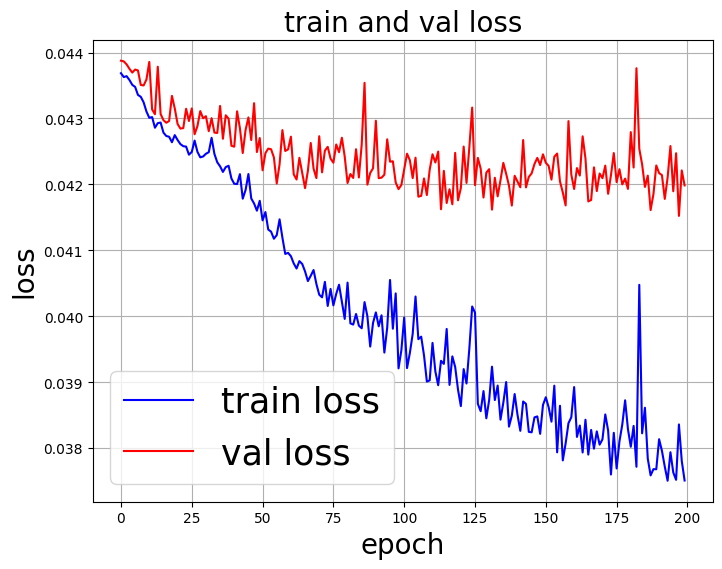

In [29]:
num_epochs = 200
fig, ax = plt.subplots(figsize=(8, 6), dpi=100)
ax.plot(range(num_epochs), train_loss_list, c='b', label='train loss')
ax.plot(range(num_epochs), test_loss_list, c='r', label='val loss')
ax.set_xlabel('epoch', fontsize='20')
ax.set_ylabel('loss', fontsize='20')
ax.set_title('train and val loss', fontsize='20')
ax.grid()
ax.legend(fontsize='25')
plt.show()

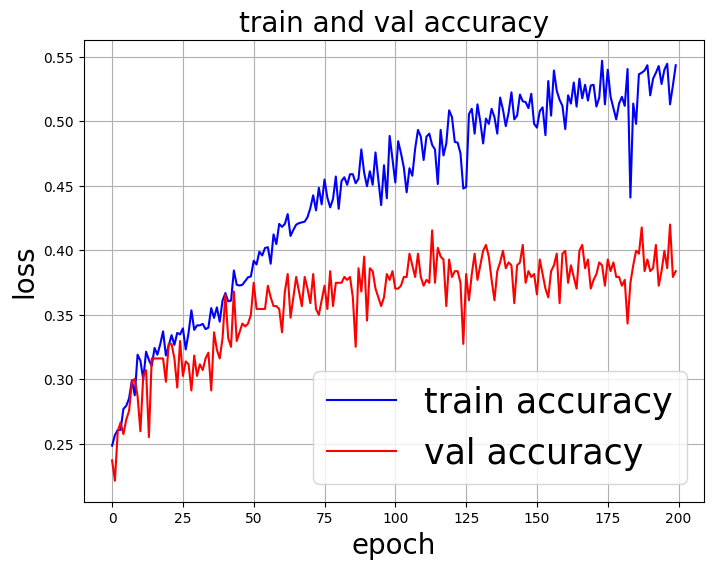

In [30]:
num_epochs = 200
fig, ax = plt.subplots(figsize=(8, 6), dpi=100)
ax.plot(range(num_epochs), train_acc_list, c='b', label='train accuracy')
ax.plot(range(num_epochs), test_acc_list, c='r', label='val accuracy')
ax.set_xlabel('epoch', fontsize='20')
ax.set_ylabel('loss', fontsize='20')
ax.set_title('train and val accuracy', fontsize='20')
ax.grid()
ax.legend(fontsize='25')
plt.show()

In [31]:
#!pip install torchsummary
from torchsummary import summary
model = ViT(patch_h=22, patch_w=2, hidden_d=8, n_blocks=2, n_heads=2)
summary(model, (1, 22, 1000))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 500, 8]             360
         LayerNorm-2               [-1, 501, 8]              16
            Linear-3                    [-1, 4]              20
            Linear-4                    [-1, 4]              20
            Linear-5                    [-1, 4]              20
           Softmax-6                  [-1, 501]               0
            Linear-7                    [-1, 4]              20
            Linear-8                    [-1, 4]              20
            Linear-9                    [-1, 4]              20
          Softmax-10                  [-1, 501]               0
           Linear-11                    [-1, 4]              20
           Linear-12                    [-1, 4]              20
           Linear-13                    [-1, 4]              20
          Softmax-14                  [